In [1]:
!pip install Spotipy

In [7]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2
import random
from functools import reduce

import json, os
import traceback
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

if os.path.exists('resources/creds.json'): 
    creds = json.load(open('resources/creds.json'))
else:
    print('Aborting authentication; cannot go further')
try: 
    cid = creds['cid']
    secret = creds['secret']
    username= creds['username']
    redirect_uri = creds['redirect_uri']


    # Once the Authorisation is complete, we just need to `sp` to call the APIs
    scope = 'user-top-read user-read-recently-played user-follow-read playlist-modify-public user-library-read playlist-read-collaborative'
    token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

    if token:
        sp = spotipy.Spotify(auth=token)
    else:
        print("Can't get token for", username)
except: 
    print(traceback.format_exc(5))
    print("Input credential information in resources/creds.json, and try again")

In [9]:
results_top_tracks = sp.current_user_top_tracks(limit=25, offset=0,time_range='medium_term')
results_top_tracks

{'items': [{'album': {'album_type': 'ALBUM',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7tGHkhWqzVJE8VbEgCb4ms'},
      'href': 'https://api.spotify.com/v1/artists/7tGHkhWqzVJE8VbEgCb4ms',
      'id': '7tGHkhWqzVJE8VbEgCb4ms',
      'name': 'Satyajit Ray',
      'type': 'artist',
      'uri': 'spotify:artist:7tGHkhWqzVJE8VbEgCb4ms'}],
    'available_markets': ['AD',
     'AE',
     'AR',
     'AT',
     'AU',
     'BE',
     'BG',
     'BH',
     'BO',
     'BR',
     'CA',
     'CH',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DE',
     'DK',
     'DO',
     'DZ',
     'EC',
     'EE',
     'EG',
     'ES',
     'FI',
     'FR',
     'GB',
     'GR',
     'GT',
     'HK',
     'HN',
     'HU',
     'ID',
     'IE',
     'IL',
     'IN',
     'IS',
     'IT',
     'JO',
     'JP',
     'KW',
     'LB',
     'LI',
     'LT',
     'LU',
     'LV',
     'MA',
     'MC',
     'MT',
     'MX',
     'MY',
     'NI',
     'NL',
     'NO',
 

In [12]:
results_recently_played = sp.current_user_recently_played(limit=25)
# results_try = sp.current_user_saved_tracks(limit = 50, offset= 0)
results_recently_played

{'items': [{'track': {'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2MR9heDhoarvkqoAjhj0iH'},
       'href': 'https://api.spotify.com/v1/artists/2MR9heDhoarvkqoAjhj0iH',
       'id': '2MR9heDhoarvkqoAjhj0iH',
       'name': 'Kanniks Kannikeswaran',
       'type': 'artist',
       'uri': 'spotify:artist:2MR9heDhoarvkqoAjhj0iH'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ',
      'DE',
      'DJ',
      'DK',
      'DM',
      'DO',
      'DZ',
      'EC',
      'EE',
     

In [13]:
results_top_tracks = sp.current_user_top_tracks(limit=25, offset=0,time_range='medium_term')
results_recently_played = sp.current_user_recently_played(limit=25)
all_results = {}
all_results['items'] = results_top_tracks['items']
print(type(results['items']))
for ind, item in enumerate(results_recently_played['items']): 
    all_results['items'] = all_results['items'] + [results_recently_played['items'][ind]['track']]

# all_results['items'] += results_try['items']
results = all_results

<class 'list'>


In [14]:
# Convert it to Dataframe
track_name = []
track_id = []
artist = []
artist_id = []
album = []
duration = []
popularity = []
for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        artist_id.append(items["artists"][0]["id"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_favorite = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "artist_id": artist_id,
                             "duration": duration, 
                             "popularity": popularity})

df_favorite

,track_name,album,track_id,artist,artist_id,duration,popularity
0,Apur Sansar (The World Of Apu),The Masterworks Of Satyajit Ray,6tFzWFRM5n8GyMLVvzzjUB,Satyajit Ray,7tGHkhWqzVJE8VbEgCb4ms,397618,15
1,Teen Kanya (Two Daughters),The Masterworks Of Satyajit Ray,16kpILLsjRqhr6CVswjdXN,Satyajit Ray,7tGHkhWqzVJE8VbEgCb4ms,182067,15
2,Behaag Thillana,Thillana Thillana,2A3Ivplogx6qpjFdHmg6fR,Jayanthi Kumaresh,3Zbm5f0WBZM9ChNuTBbLsT,324841,14
3,Aparajito (The Unvanquished),The Masterworks Of Satyajit Ray,3FviQsYNiXlIuct5h62naN,Satyajit Ray,7tGHkhWqzVJE8VbEgCb4ms,105348,12
4,Nirvana Shatkam,Nirvana Shatkam,65EHSgLcqGSa6enQwSI6st,Ranjani-Gayatri,1yboBrfDMPU8uu5FtjXKuv,376362,0
5,Kanakanaruchira - Varali - Adi,Thiyagaraja Pancharatna Krithis,6D45t66KFQOTINOZZQOWg3,Bombay Jayashri,5OTt6O4Q22YsqZDaWV6FqC,829693,3
6,Devi (The Goddess),The Masterworks Of Satyajit Ray,03JXWFaseeAbDroQToYxSL,Satyajit Ray,7tGHkhWqzVJE8VbEgCb4ms,503222,9
7,Charulata (The Lonely Wife),The Masterworks Of Satyajit Ray,4autxELjxrZi5w4TfPyQPP,Satyajit Ray,7tGHkhWqzVJE8VbEgCb4ms,585746,13
8,Arabhi Varnam - Raga : Arabi,Vasantham - Violin,2OazlGCnamMc0EJImVxebc,Ganesh,1lpAD2Qk6jE2f8RZpShBzU,221666,8
9,Endaro Manahanu - Sri - Adi,Thiyagaraja Pancharatna Krithis,50HrU2shq9UE3lFU9ZUXbr,Ranjani-Gayatri,1yboBrfDMPU8uu5FtjXKuv,698840,1


In [15]:
def fetch_audio_features(sp, df):
    playlist = df[['track_id','track_name', 'artist_id']] 
    index = 0
    audio_features = []
    genres = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
        
    index = 0
    while index < playlist.shape[0]:
        genres += [sp.artist('spotify:artist:'+ playlist.iloc[index, 2])['genres']]
        index += 1
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness'],
                              features['mode']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness','duration_ms', 'key',
                                                             'valence', 'speechiness', 'mode',])
    df_audio_features['genres'] = genres
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [16]:
df_fav = fetch_audio_features (sp, df_favorite)
df_fav

,track_id,artist_id,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,duration_ms,key,valence,speechiness,mode,genres
track_name,,,,,,,,,,,,,,,
Apur Sansar (The World Of Apu),6tFzWFRM5n8GyMLVvzzjUB,7tGHkhWqzVJE8VbEgCb4ms,0.185,0.92500,0.13800,101.919,0.711000,-18.267,0.1520,397619,6,0.1030,0.0414,1,[]
Teen Kanya (Two Daughters),16kpILLsjRqhr6CVswjdXN,7tGHkhWqzVJE8VbEgCb4ms,0.260,0.90000,0.36600,99.590,0.788000,-12.500,0.3020,182068,2,0.1950,0.0328,1,[]
Behaag Thillana,2A3Ivplogx6qpjFdHmg6fR,3Zbm5f0WBZM9ChNuTBbLsT,0.812,0.89700,0.50600,116.059,0.866000,-10.937,0.1230,324841,4,0.6520,0.0345,1,"[carnatic, carnatic instrumental, indian class..."
Aparajito (The Unvanquished),3FviQsYNiXlIuct5h62naN,7tGHkhWqzVJE8VbEgCb4ms,0.372,0.95900,0.23800,131.413,0.676000,-20.262,0.1180,105349,2,0.1330,0.0592,1,[]
Nirvana Shatkam,65EHSgLcqGSa6enQwSI6st,1yboBrfDMPU8uu5FtjXKuv,0.588,0.73600,0.51000,115.010,0.000000,-10.267,0.3300,376362,1,0.4220,0.0670,0,"[carnatic, carnatic vocal, indian classical]"
Kanakanaruchira - Varali - Adi,6D45t66KFQOTINOZZQOWg3,5OTt6O4Q22YsqZDaWV6FqC,0.348,0.85500,0.60000,157.345,0.000042,-6.124,0.0962,829694,8,0.4740,0.0503,1,"[carnatic, carnatic vocal, filmi, indian class..."
Devi (The Goddess),03JXWFaseeAbDroQToYxSL,7tGHkhWqzVJE8VbEgCb4ms,0.383,0.92500,0.20600,152.224,0.002050,-16.912,0.1060,503223,5,0.2280,0.0958,0,[]
Charulata (The Lonely Wife),4autxELjxrZi5w4TfPyQPP,7tGHkhWqzVJE8VbEgCb4ms,0.310,0.97900,0.16800,171.142,0.000209,-16.724,0.4460,585747,2,0.1130,0.0670,1,[]
Arabhi Varnam - Raga : Arabi,2OazlGCnamMc0EJImVxebc,1lpAD2Qk6jE2f8RZpShBzU,0.434,0.76100,0.54200,105.264,0.928000,-13.679,0.1460,221667,6,0.8310,0.0595,1,[]


In [17]:
df_fav.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, Apur Sansar (The World Of Apu) to Charu's Theme from Satyajit Ray's film CHARULATA
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          45 non-null     object 
 1   artist_id         45 non-null     object 
 2   danceability      45 non-null     float64
 3   acousticness      45 non-null     float64
 4   energy            45 non-null     float64
 5   tempo             45 non-null     float64
 6   instrumentalness  45 non-null     float64
 7   loudness          45 non-null     float64
 8   liveness          45 non-null     float64
 9   duration_ms       45 non-null     int64  
 10  key               45 non-null     int64  
 11  valence           45 non-null     float64
 12  speechiness       45 non-null     float64
 13  mode              45 non-null     int64  
 14  genres            45 non-null     object 
dtypes: float64(9), int64(3)

/Users/tejasbot/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


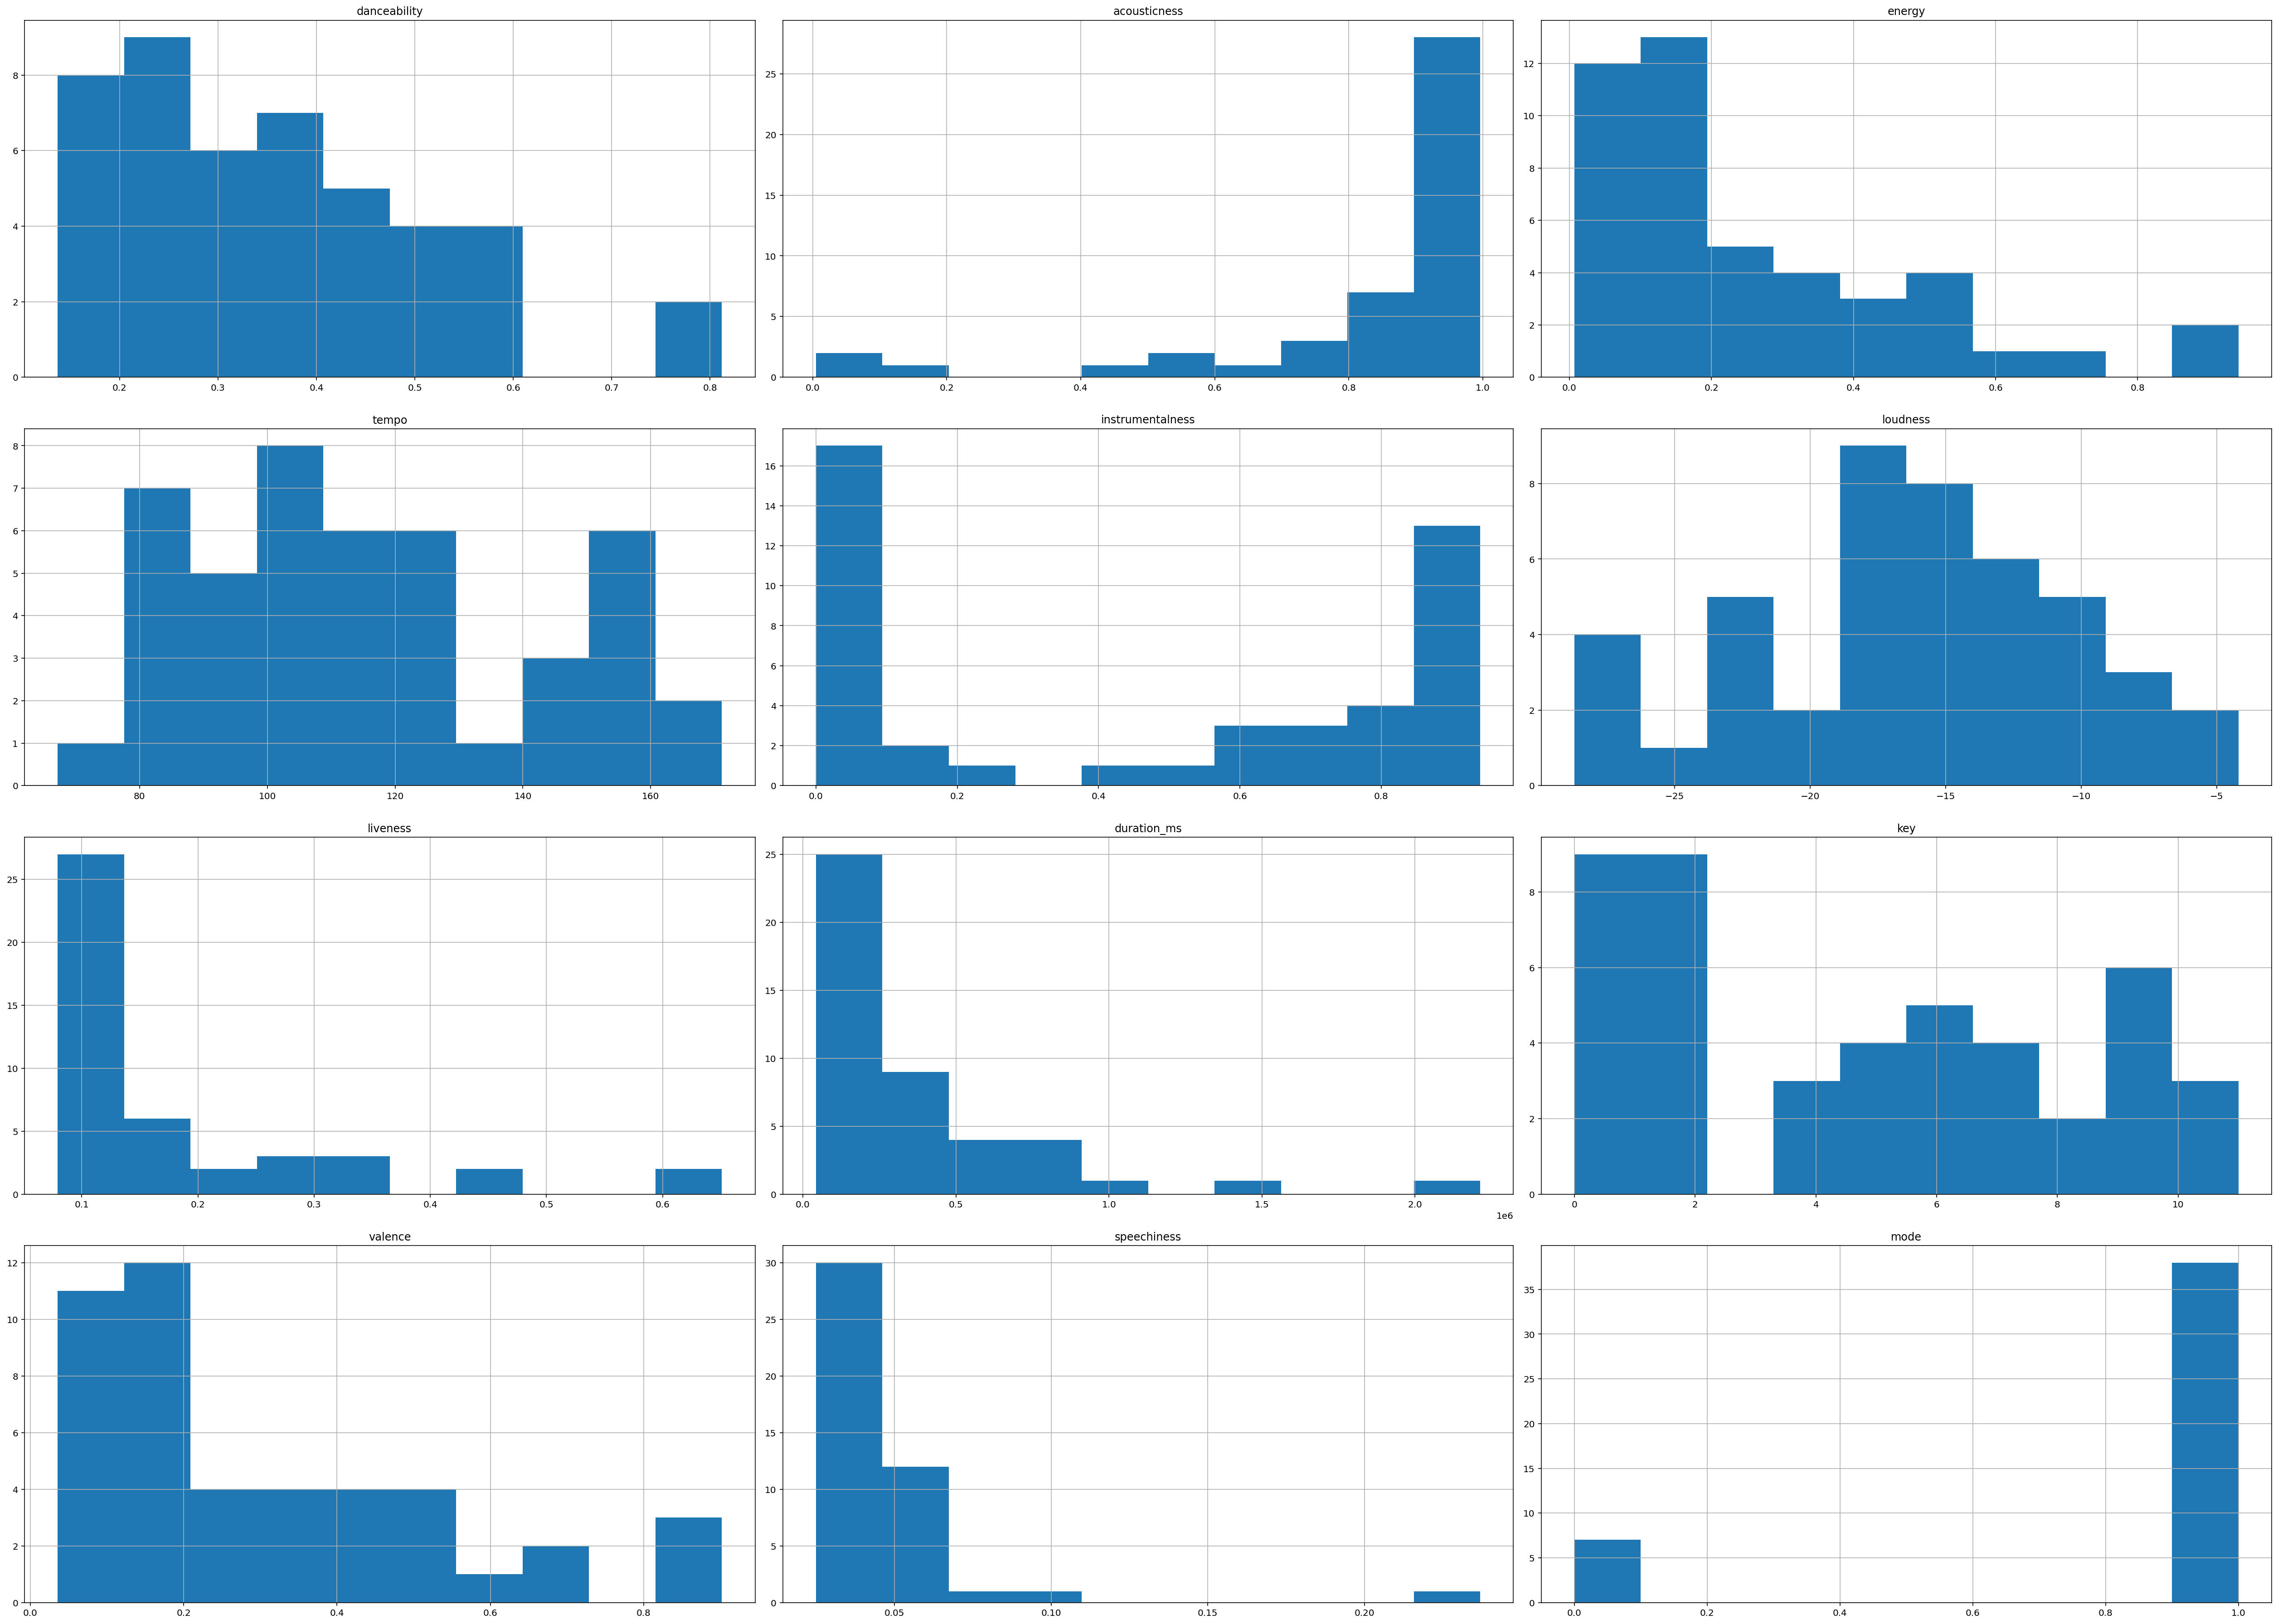

In [18]:
df_fav.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()

In [21]:
def featured_playlists(sp, username):
    id = []
    name = []
    num_tracks = []
 # For looping through the API request  
    playlists = sp.user_playlists(username)#Replace with user id
    for i, items in enumerate(playlists['items']):
        id.append(items['id'])
        name.append(items['name'])
        num_tracks.append(items['tracks']['total'])

# Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [22]:
df_playlists = featured_playlists(sp, creds['username'])
df_playlists

,id,name,#tracks
0,6964IGSaWB408klAN6ucQP,JS Blend2,0
1,6AxSmutSvL4zepLOAfpgSc,JS Blend2,50
2,2ZSR6zt1YF8FBdfuvw6KNc,Rudra Veena,9
3,4LJMgDqw8LBDZ5ERzxfQ0g,Fanna Fi Allah,3
4,0DcztO02Tox6mIEGfbYJIr,JS Blend2,0
5,1kgaY77cpRDGhcYmVNHvdV,karaoke,1
6,72GrzHx43yw0nHa3BuAPrL,Craig Pruess and the Singers of the Art of Liv...,6
7,3PTg0gKdhPv9TPJmw60KSz,Shankar - Raga Aberi,8
8,1rTvmcaTynZIg6VqGxjphk,"Various Artists - The Best Of Carnatic Vocal, ...",14
9,6n6jIjZy2Vg9VCMx6Swv6y,Various Artists - Varnams,22


In [23]:
def fetch_playlist_tracks(sp, playlistsid): 
    offset = 0
    tracks = []
    # Make the API request
    while True:
            content = sp.playlist_tracks( playlistsid, fields=None, limit=100, offset=offset, market=None)
            tracks += content['items']
        
            if content['next'] is not None:
                offset += 100
            else:
                break
    
    track_id = []
    track_name = []
    
    for track in tracks:
        track_id.append(track['track']['id'])
        track_name.append(track['track']['name'])
    
# Create the final df
    df_playlists_tracks = pd.DataFrame({"track_id":track_id, "track_name": track_name})
    return df_playlists_tracks

In [24]:
def fetch_audio_features(sp, playlist_id):
    playlist = fetch_playlist_tracks(sp, playlist_id)
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness', 'duration_ms', 'key',
                                                             'valence', 'speechiness'])
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [25]:
# Build the dtaframe froms the playlists
for i, playlist in enumerate(df_playlists['id']):
    try:
        string_command = "df_{} = fetch_audio_features(sp, playlist)".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass

Create df_6964IGSaWB408klAN6ucQP = fetch_audio_features(sp, playlist)
Create df_6AxSmutSvL4zepLOAfpgSc = fetch_audio_features(sp, playlist)
Create df_2ZSR6zt1YF8FBdfuvw6KNc = fetch_audio_features(sp, playlist)
Create df_4LJMgDqw8LBDZ5ERzxfQ0g = fetch_audio_features(sp, playlist)
Create df_0DcztO02Tox6mIEGfbYJIr = fetch_audio_features(sp, playlist)
Create df_1kgaY77cpRDGhcYmVNHvdV = fetch_audio_features(sp, playlist)
Create df_72GrzHx43yw0nHa3BuAPrL = fetch_audio_features(sp, playlist)
Create df_3PTg0gKdhPv9TPJmw60KSz = fetch_audio_features(sp, playlist)
Create df_1rTvmcaTynZIg6VqGxjphk = fetch_audio_features(sp, playlist)
Create df_6n6jIjZy2Vg9VCMx6Swv6y = fetch_audio_features(sp, playlist)
Create df_2OFmUyEWo5LaCfEMv5zZdR = fetch_audio_features(sp, playlist)
Create df_7AR1r6RMIxZzfXp1JBvAhj = fetch_audio_features(sp, playlist)
Create df_1KkrVONQgCv9ijVE3j9NqS = fetch_audio_features(sp, playlist)
Create df_5RAFOgwi4AtumrEG7KeHWH = fetch_audio_features(sp, playlist)
Create df_6ZSuc73ggK

In [26]:
def fetch_audio_features_mean(sp, playlist_id):
    Playlist = fetch_audio_features(sp, playlist_id)#df_playlist_audio_features(sp, playlist_id)
    return pd.DataFrame(Playlist.mean(), columns= [playlist_id])

In [29]:
# Merge them together
import numpy
dataframes = []
# Loop through the filenames to populate dataframes with different dataframes 
for  playlist in df_playlists['id']:
    try:
        mean_df = fetch_audio_features_mean(sp, playlist)

        if any(numpy.isnan(mean_df.values)): 
            
            print ("Skip "+playlist)
            continue
        dataframes.append(mean_df)
    except:
        print ("Skip "+playlist)

Skip 6964IGSaWB408klAN6ucQP
Skip 0DcztO02Tox6mIEGfbYJIr
Skip 7nFRkJjRbA7YkOBZKhpw7j


In [30]:
dataframes

[                  6AxSmutSvL4zepLOAfpgSc
 danceability                    0.300194
 acousticness                    0.882940
 energy                          0.183625
 tempo                         103.137820
 instrumentalness                0.624802
 loudness                      -17.932140
 liveness                        0.138746
 duration_ms                281568.020000
 key                             4.480000
 valence                         0.247646
 speechiness                     0.041686,
                   2ZSR6zt1YF8FBdfuvw6KNc
 danceability                3.502222e-01
 acousticness                7.993333e-01
 energy                      2.970667e-01
 tempo                       1.195447e+02
 instrumentalness            5.196667e-01
 loudness                   -1.946933e+01
 liveness                    2.737222e-01
 duration_ms                 1.191608e+06
 key                         4.111111e+00
 valence                     2.755333e-01
 speechiness                 4.65

In [31]:
X = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes)
X

,6AxSmutSvL4zepLOAfpgSc,2ZSR6zt1YF8FBdfuvw6KNc,4LJMgDqw8LBDZ5ERzxfQ0g,1kgaY77cpRDGhcYmVNHvdV,72GrzHx43yw0nHa3BuAPrL,3PTg0gKdhPv9TPJmw60KSz,1rTvmcaTynZIg6VqGxjphk,6n6jIjZy2Vg9VCMx6Swv6y,2OFmUyEWo5LaCfEMv5zZdR,7AR1r6RMIxZzfXp1JBvAhj,1KkrVONQgCv9ijVE3j9NqS,5RAFOgwi4AtumrEG7KeHWH,6ZSuc73ggKacdq50SxbZwJ,5DCbt84RG5uf2DbRTzybT0,2IWxWGVN1vz4DMdh3lrKYZ,0XcJjckAXfv02QfQkqFkXr
danceability,0.300194,3.502222e-01,0.401333,0.4440,0.201517,0.476125,0.392143,0.416909,5.193333e-01,0.319973,0.312750,0.472545,0.276280,0.583000,0.384880,0.519615
acousticness,0.882940,7.993333e-01,0.056270,0.7350,0.916000,0.520666,0.819929,0.743591,6.976667e-01,0.878500,0.933375,0.644514,0.931260,0.337651,0.621880,0.546077
energy,0.183625,2.970667e-01,0.740333,0.5910,0.170167,0.503000,0.525071,0.603455,6.176667e-01,0.193335,0.293625,0.418709,0.140611,0.585000,0.657240,0.705923
tempo,103.137820,1.195447e+02,115.697000,82.9520,98.088667,85.087875,137.577071,138.897864,1.657390e+02,94.847115,125.991625,113.842591,97.705160,115.918909,121.264760,129.372000
instrumentalness,0.624802,5.196667e-01,0.351947,0.0000,0.002140,0.765750,0.017584,0.035878,1.668022e-01,0.318358,0.496907,0.479289,0.765331,0.189196,0.472464,0.736493
loudness,-17.932140,-1.946933e+01,-9.042667,-10.0020,-16.691667,-13.549250,-11.447143,-9.954318,-8.768667e+00,-18.276115,-16.181875,-11.626500,-20.584510,-10.165909,-11.095280,-20.577538
liveness,0.138746,2.737222e-01,0.540000,0.0734,0.123450,0.201500,0.175486,0.211655,1.573333e-01,0.140604,0.201625,0.177473,0.148308,0.193027,0.329392,0.130354
duration_ms,281568.020000,1.191608e+06,886124.333333,271581.0000,686155.333333,364161.625000,577384.785714,427728.272727,1.273367e+06,152876.884615,493813.125000,152609.000000,420948.270000,328276.363636,688347.520000,400993.846154
key,4.480000,4.111111e+00,4.333333,1.0000,5.000000,9.500000,5.785714,6.318182,5.000000e+00,5.538462,4.250000,4.000000,4.950000,4.818182,4.440000,2.846154
valence,0.247646,2.755333e-01,0.727333,0.5870,0.129333,0.579125,0.475643,0.651364,4.746667e-01,0.623769,0.171613,0.495809,0.193686,0.375909,0.501736,0.673385


In [32]:
Y = pd.DataFrame(df_fav.median(), columns= ['fav_playlist'])
Y= Y.drop('mode')
Y

,fav_playlist
danceability,0.3370
acousticness,0.9250
energy,0.1870
tempo,112.4540
instrumentalness,0.6100
loudness,-15.7920
liveness,0.1200
duration_ms,221360.0000
key,5.0000
valence,0.2000


In [33]:
# Analyze feature importances
from sklearn.ensemble._forest import RandomForestRegressor
# Can combine step above with this
forest = RandomForestRegressor(n_estimators=10)#random_state=42, max_depth=2, max_features=9) 
forest.fit(X,Y.values.ravel())
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature rankings
print("Playlist ranking:")
  
for f in range(len(importances)):
    print("%d. %s %f " % (f + 1, 
            X.columns[indices[f]], 
            importances[indices[f]]))

Playlist ranking:
1. 0XcJjckAXfv02QfQkqFkXr 0.200069 
2. 6ZSuc73ggKacdq50SxbZwJ 0.200000 
3. 1rTvmcaTynZIg6VqGxjphk 0.100001 
4. 1KkrVONQgCv9ijVE3j9NqS 0.100000 
5. 2OFmUyEWo5LaCfEMv5zZdR 0.100000 
6. 2IWxWGVN1vz4DMdh3lrKYZ 0.100000 
7. 6AxSmutSvL4zepLOAfpgSc 0.099670 
8. 5RAFOgwi4AtumrEG7KeHWH 0.099074 
9. 6n6jIjZy2Vg9VCMx6Swv6y 0.000855 
10. 72GrzHx43yw0nHa3BuAPrL 0.000330 
11. 1kgaY77cpRDGhcYmVNHvdV 0.000000 
12. 5DCbt84RG5uf2DbRTzybT0 0.000000 
13. 7AR1r6RMIxZzfXp1JBvAhj 0.000000 
14. 4LJMgDqw8LBDZ5ERzxfQ0g 0.000000 
15. 3PTg0gKdhPv9TPJmw60KSz 0.000000 
16. 2ZSR6zt1YF8FBdfuvw6KNc 0.000000 


In [34]:
frames = []
for i, playlist in enumerate(df_playlists['id']):
    try:
        string_command = "frames.append(df_{})".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass
print (frames)
df =pd.concat(frames)
df.drop_duplicates()
df

Create frames.append(df_6964IGSaWB408klAN6ucQP)
Create frames.append(df_6AxSmutSvL4zepLOAfpgSc)
Create frames.append(df_2ZSR6zt1YF8FBdfuvw6KNc)
Create frames.append(df_4LJMgDqw8LBDZ5ERzxfQ0g)
Create frames.append(df_0DcztO02Tox6mIEGfbYJIr)
Create frames.append(df_1kgaY77cpRDGhcYmVNHvdV)
Create frames.append(df_72GrzHx43yw0nHa3BuAPrL)
Create frames.append(df_3PTg0gKdhPv9TPJmw60KSz)
Create frames.append(df_1rTvmcaTynZIg6VqGxjphk)
Create frames.append(df_6n6jIjZy2Vg9VCMx6Swv6y)
Create frames.append(df_2OFmUyEWo5LaCfEMv5zZdR)
Create frames.append(df_7AR1r6RMIxZzfXp1JBvAhj)
Create frames.append(df_1KkrVONQgCv9ijVE3j9NqS)
Create frames.append(df_5RAFOgwi4AtumrEG7KeHWH)
Create frames.append(df_6ZSuc73ggKacdq50SxbZwJ)
Create frames.append(df_5DCbt84RG5uf2DbRTzybT0)
Create frames.append(df_2IWxWGVN1vz4DMdh3lrKYZ)
Create frames.append(df_0XcJjckAXfv02QfQkqFkXr)
Create frames.append(df_7nFRkJjRbA7YkOBZKhpw7j)
playlist with id 7nFRkJjRbA7YkOBZKhpw7j is not valid, skiping 
[Empty DataFrame
Columns:

,track_id,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,duration_ms,key,valence,speechiness
track_name,,,,,,,,,,,,
"Concerto No. 1 in E-Flat Major for Piano and Orchestra, S. 124: II. Quasi adagio",7tXLXpjVFwsNbmzgygvA8x,0.1980,0.964,0.0115,88.666,0.8720,-34.507,0.1080,278200,11,0.0364,0.0372
"Concerto in C Major for Sopranino Recorder, Strings and B.C, RV 444: II. Largo",1zVbg5IaZBgEqie00InFK0,0.2370,0.950,0.0807,59.255,0.0177,-18.110,0.2510,150413,9,0.3020,0.0480
"Symphony No. 8 in B Minor, D. 759, ""The Unfinished"": II. Andante con moto",6KBugd39vcZEFkqRAw87Ec,0.0971,0.982,0.0151,87.828,0.8160,-24.432,0.0695,630840,4,0.0383,0.0389
"Concerto No. 9 in B-Flat Major for Cello and Orchestra, G. 482 (Ed. Grützmacher): II. Adagio non troppo",1hQRBmekXZ3nWUD3XY0UQM,0.0789,0.986,0.0723,174.437,0.8670,-22.477,0.0709,360067,7,0.0396,0.0500
Lakes Of Silgo / Top Of Maol,61M48jRlfStiKdbuMc1Cbo,0.3340,0.679,0.1370,91.977,0.0124,-16.678,0.3050,94560,2,0.7730,0.0423
...,...,...,...,...,...,...,...,...,...,...,...,...
Qaida In Four,64Wf0OnCvdq2uVxrUCJOsq,0.4990,0.133,0.8390,141.027,0.7650,-22.837,0.0883,191797,1,0.9580,0.1170
Quadrospect,14EYVKNIgesnKeaq92b8Zd,0.5090,0.481,0.8910,139.575,0.9050,-22.596,0.0564,219707,8,0.6590,0.0784
Lahra & Jhala In Dipchandi,5dJEx7XVIMB8H5yhrxzJkd,0.4610,0.898,0.7340,148.379,0.8810,-15.966,0.0974,212555,1,0.6250,0.0739


In [35]:
df = df.set_index(['track_id'])
df

,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,duration_ms,key,valence,speechiness
track_id,,,,,,,,,,,
7tXLXpjVFwsNbmzgygvA8x,0.1980,0.964,0.0115,88.666,0.8720,-34.507,0.1080,278200,11,0.0364,0.0372
1zVbg5IaZBgEqie00InFK0,0.2370,0.950,0.0807,59.255,0.0177,-18.110,0.2510,150413,9,0.3020,0.0480
6KBugd39vcZEFkqRAw87Ec,0.0971,0.982,0.0151,87.828,0.8160,-24.432,0.0695,630840,4,0.0383,0.0389
1hQRBmekXZ3nWUD3XY0UQM,0.0789,0.986,0.0723,174.437,0.8670,-22.477,0.0709,360067,7,0.0396,0.0500
61M48jRlfStiKdbuMc1Cbo,0.3340,0.679,0.1370,91.977,0.0124,-16.678,0.3050,94560,2,0.7730,0.0423
...,...,...,...,...,...,...,...,...,...,...,...
64Wf0OnCvdq2uVxrUCJOsq,0.4990,0.133,0.8390,141.027,0.7650,-22.837,0.0883,191797,1,0.9580,0.1170
14EYVKNIgesnKeaq92b8Zd,0.5090,0.481,0.8910,139.575,0.9050,-22.596,0.0564,219707,8,0.6590,0.0784
5dJEx7XVIMB8H5yhrxzJkd,0.4610,0.898,0.7340,148.379,0.8810,-15.966,0.0974,212555,1,0.6250,0.0739


In [36]:
# CO
Y= Y.squeeze('columns')

In [37]:
Y = Y.sort_index( axis=0, level=None, ascending=True, inplace=False, kind='quicksort')
Y

acousticness             0.9250
danceability             0.3370
duration_ms         221360.0000
energy                   0.1870
instrumentalness         0.6100
key                      5.0000
liveness                 0.1200
loudness               -15.7920
speechiness              0.0395
tempo                  112.4540
valence                  0.2000
Name: fav_playlist, dtype: float64

In [38]:
# Subtract mean of the favorite plalyist from the top 3 playlist 
df1= df.subtract(Y, axis='columns') 
df1

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence
track_id,,,,,,,,,,,
7tXLXpjVFwsNbmzgygvA8x,0.039,-0.1390,56840,-0.1755,0.2620,6,-0.0120,-18.715,-0.0023,-23.788,-0.1636
1zVbg5IaZBgEqie00InFK0,0.025,-0.1000,-70947,-0.1063,-0.5923,4,0.1310,-2.318,0.0085,-53.199,0.1020
6KBugd39vcZEFkqRAw87Ec,0.057,-0.2399,409480,-0.1719,0.2060,-1,-0.0505,-8.640,-0.0006,-24.626,-0.1617
1hQRBmekXZ3nWUD3XY0UQM,0.061,-0.2581,138707,-0.1147,0.2570,2,-0.0491,-6.685,0.0105,61.983,-0.1604
61M48jRlfStiKdbuMc1Cbo,-0.246,-0.0030,-126800,-0.0500,-0.5976,-3,0.1850,-0.886,0.0028,-20.477,0.5730
...,...,...,...,...,...,...,...,...,...,...,...
64Wf0OnCvdq2uVxrUCJOsq,-0.792,0.1620,-29563,0.6520,0.1550,-4,-0.0317,-7.045,0.0775,28.573,0.7580
14EYVKNIgesnKeaq92b8Zd,-0.444,0.1720,-1653,0.7040,0.2950,3,-0.0636,-6.804,0.0389,27.121,0.4590
5dJEx7XVIMB8H5yhrxzJkd,-0.027,0.1240,-8805,0.5470,0.2710,-4,-0.0226,-0.174,0.0344,35.925,0.4250


In [39]:
df1= df1.divide(Y, axis='columns') 
df1

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence
track_id,,,,,,,,,,,
7tXLXpjVFwsNbmzgygvA8x,0.042162,-0.412463,0.256776,-0.938503,0.429508,1.2,-0.100000,1.185094,-0.058228,-0.211535,-0.8180
1zVbg5IaZBgEqie00InFK0,0.027027,-0.296736,-0.320505,-0.568449,-0.970984,0.8,1.091667,0.146783,0.215190,-0.473073,0.5100
6KBugd39vcZEFkqRAw87Ec,0.061622,-0.711869,1.84984,-0.919251,0.337705,-0.2,-0.420833,0.547112,-0.015190,-0.218987,-0.8085
1hQRBmekXZ3nWUD3XY0UQM,0.065946,-0.765875,0.626613,-0.613369,0.421311,0.4,-0.409167,0.423316,0.265823,0.551185,-0.8020
61M48jRlfStiKdbuMc1Cbo,-0.265946,-0.008902,-0.572823,-0.267380,-0.979672,-0.6,1.541667,0.056104,0.070886,-0.182092,2.8650
...,...,...,...,...,...,...,...,...,...,...,...
64Wf0OnCvdq2uVxrUCJOsq,-0.856216,0.480712,-0.133552,3.486631,0.254098,-0.8,-0.264167,0.446112,1.962025,0.254086,3.7900
14EYVKNIgesnKeaq92b8Zd,-0.480000,0.510386,-0.00746747,3.764706,0.483607,0.6,-0.530000,0.430851,0.984810,0.241174,2.2950
5dJEx7XVIMB8H5yhrxzJkd,-0.029189,0.367953,-0.0397768,2.925134,0.444262,-0.8,-0.188333,0.011018,0.870886,0.319464,2.1250


In [799]:
df1 = df1.drop(['instrumentalness'], axis=1)

In [40]:
# Add all the score 
df1['variation'] = df1.sum(axis=1)
# take the absoulte of the variatio
df1['variation'] = df1['variation'].abs()
df1 = df1.drop_duplicates()
df1

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,variation
track_id,,,,,,,,,,,,
7tXLXpjVFwsNbmzgygvA8x,0.042162,-0.412463,0.256776,-0.938503,0.429508,1.2,-0.100000,1.185094,-0.058228,-0.211535,-0.8180,0.574812
1zVbg5IaZBgEqie00InFK0,0.027027,-0.296736,-0.320505,-0.568449,-0.970984,0.8,1.091667,0.146783,0.215190,-0.473073,0.5100,0.160920
6KBugd39vcZEFkqRAw87Ec,0.061622,-0.711869,1.84984,-0.919251,0.337705,-0.2,-0.420833,0.547112,-0.015190,-0.218987,-0.8085,0.498355
1hQRBmekXZ3nWUD3XY0UQM,0.065946,-0.765875,0.626613,-0.613369,0.421311,0.4,-0.409167,0.423316,0.265823,0.551185,-0.8020,0.163783
61M48jRlfStiKdbuMc1Cbo,-0.265946,-0.008902,-0.572823,-0.267380,-0.979672,-0.6,1.541667,0.056104,0.070886,-0.182092,2.8650,1.656842
...,...,...,...,...,...,...,...,...,...,...,...,...
64Wf0OnCvdq2uVxrUCJOsq,-0.856216,0.480712,-0.133552,3.486631,0.254098,-0.8,-0.264167,0.446112,1.962025,0.254086,3.7900,8.619730
14EYVKNIgesnKeaq92b8Zd,-0.480000,0.510386,-0.00746747,3.764706,0.483607,0.6,-0.530000,0.430851,0.984810,0.241174,2.2950,8.293066
5dJEx7XVIMB8H5yhrxzJkd,-0.029189,0.367953,-0.0397768,2.925134,0.444262,-0.8,-0.188333,0.011018,0.870886,0.319464,2.1250,6.006417


In [41]:
# Now we have the variation, we will take the songs with the least variation 
df2 = df1.nsmallest(50,'variation', keep='first')
df2

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,variation
track_id,,,,,,,,,,,,
3FviQsYNiXlIuct5h62naN,0.036757,0.103858,-0.524083,0.272727,0.108197,-0.6,-0.016667,0.283055,0.498734,0.168593,-0.3350,0.003829
7kyM3yALIIOkczxvvUlbNB,0.067027,-0.293769,-0.330683,-0.970428,-0.250820,0.2,0.016667,1.286727,0.131646,-0.221317,0.3700,0.005050
4ksGuAeANt8PnrIfmPgTRO,0.002162,-0.394659,0.134744,-0.262032,0.534426,0.4,0.041667,0.133295,0.060759,-0.002490,-0.5995,0.048373
4h83R41t8oX0mctk2KLCBZ,0.010811,-0.264095,-0.0999864,0.780749,0.280328,-0.6,0.933333,-0.030015,-0.022785,-0.396864,-0.5405,0.050975
1phEqddZWuf57j1xpMMgkR,0.067027,-0.305638,0.51891,-0.417112,0.521311,0.2,-0.141667,0.226887,0.045570,0.148078,-0.8040,0.059367
0MGUPPqV1injg6Ul8fIFTA,0.040000,-0.451039,-0.588304,-0.358289,0.288525,0.4,0.675000,0.211056,0.053165,-0.335746,0.1250,0.059368
3N5wC6YWaM7hviIRbnmBTw,-0.145946,0.379822,-0.26292,-0.563636,0.367213,0.4,0.258333,0.043440,0.007595,-0.061928,-0.2950,0.126973
1zVbg5IaZBgEqie00InFK0,0.027027,-0.296736,-0.320505,-0.568449,-0.970984,0.8,1.091667,0.146783,0.215190,-0.473073,0.5100,0.160920
1hQRBmekXZ3nWUD3XY0UQM,0.065946,-0.765875,0.626613,-0.613369,0.421311,0.4,-0.409167,0.423316,0.265823,0.551185,-0.8020,0.163783


In [44]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [45]:
create_playlist(sp, username, 'JS Blend2', 'Test playlist created using python!')

In [46]:
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [47]:
fetch_playlists(sp,username)

,id,name,#tracks
0,22ED33oFBgc8JzrA6yPTbl,JS Blend2,0
1,6964IGSaWB408klAN6ucQP,JS Blend2,0
2,6AxSmutSvL4zepLOAfpgSc,JS Blend2,50
3,2ZSR6zt1YF8FBdfuvw6KNc,Rudra Veena,9
4,4LJMgDqw8LBDZ5ERzxfQ0g,Fanna Fi Allah,3
5,0DcztO02Tox6mIEGfbYJIr,JS Blend2,0
6,1kgaY77cpRDGhcYmVNHvdV,karaoke,1
7,72GrzHx43yw0nHa3BuAPrL,Craig Pruess and the Singers of the Art of Liv...,6
8,3PTg0gKdhPv9TPJmw60KSz,Shankar - Raga Aberi,8
9,1rTvmcaTynZIg6VqGxjphk,"Various Artists - The Best Of Carnatic Vocal, ...",14


In [48]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 50])
        index += 50

In [49]:
list_track = df2.index

In [51]:
enrich_playlist(sp, username, '', list_track) #playlist id

In [52]:
fetch_playlists(sp,username)

,id,name,#tracks
0,22ED33oFBgc8JzrA6yPTbl,JS Blend2,0
1,6964IGSaWB408klAN6ucQP,JS Blend2,50
2,6AxSmutSvL4zepLOAfpgSc,JS Blend2,50
3,2ZSR6zt1YF8FBdfuvw6KNc,Rudra Veena,9
4,4LJMgDqw8LBDZ5ERzxfQ0g,Fanna Fi Allah,3
5,0DcztO02Tox6mIEGfbYJIr,JS Blend2,0
6,1kgaY77cpRDGhcYmVNHvdV,karaoke,1
7,72GrzHx43yw0nHa3BuAPrL,Craig Pruess and the Singers of the Art of Liv...,6
8,3PTg0gKdhPv9TPJmw60KSz,Shankar - Raga Aberi,8
9,1rTvmcaTynZIg6VqGxjphk,"Various Artists - The Best Of Carnatic Vocal, ...",14
